In [1]:
# import necessary packages
from itertools import combinations

import cdt
cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows

from dowhy import CausalModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.random import normal
import pandas as pd
import pingouin as pg
from dataclasses import dataclass, field
import seaborn as sns

np.random.seed(0)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
@dataclass
class Translation:
    
    original: str
    translated: str


@dataclass
class Attributes:
    
    is_black = Translation(original="black", translated="is_black")
    education = Translation(original="educ", translated="education")
    log_wage = Translation(original="lwage", translated="log_wage")
    experience = Translation(original="exper", translated="experience")
    is_south = Translation(original="south", translated="is_south")
    is_married = Translation(original="married", translated="is_married")
    is_urban = Translation(original="smsa", translated="is_urban")
    is_near_college = Translation(original="nearc4", translated="is_near_college")
    
    def get_all_attributes(self):
        return [
            self.education,
            self.log_wage,
            self.experience,
            self.is_south,
            self.is_married,
            self.is_urban,
            self.is_near_college,
            self.is_black
        ]
    
    def translate_attributes(self):
        return {att.original: att.translated for att in self.get_all_attributes()}
    
    
data = pd.read_stata("./data/close_college.dta")

attributes = Attributes()
data = data.rename(columns=attributes.translate_attributes())

G = nx.DiGraph()
G.add_nodes_from(data.columns)

G.add_edges_from(
    [
        (attributes.is_south.translated, attributes.is_married.translated),
        (attributes.is_south.translated, attributes.is_near_college.translated),
        
        (attributes.is_married.translated, attributes.log_wage.translated),
        
        (attributes.is_near_college.translated, attributes.education.translated),
        
        (attributes.education.translated, attributes.experience.translated),
        
        (attributes.experience.translated, attributes.log_wage.translated),
        
        (attributes.is_black.translated, attributes.is_near_college.translated),
        (attributes.is_black.translated, attributes.experience.translated),
        (attributes.is_black.translated, attributes.log_wage.translated),
        
        (attributes.is_urban.translated, attributes.is_near_college.translated),
        (attributes.is_urban.translated, attributes.log_wage.translated),
    ]
)

### Determine the skeleton

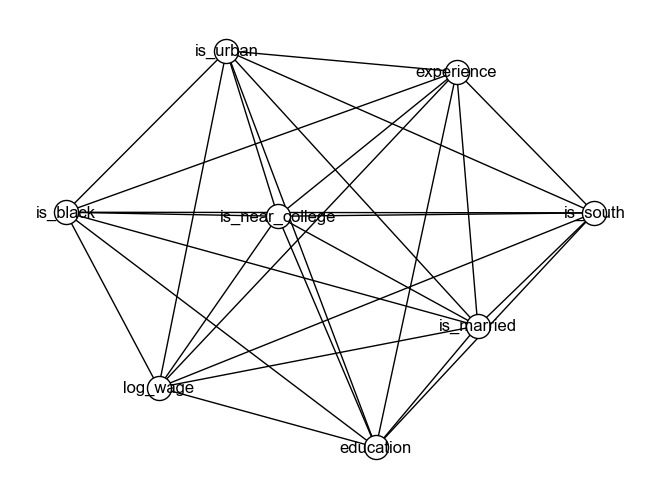

In [3]:
skeleton = nx.Graph()
skeleton.add_nodes_from(data.columns)
skeleton.add_edges_from(combinations(data.columns, 2))

nx.draw(skeleton, with_labels=True, node_color='w', edgecolors ='black')

We use conditional independence testing (Tutorial 2) between any pair of variables with a conditioning set of size $k=0$ (thus $S = \emptyset$). By default we use the significance level of 0.05. The Null hypothesis is $X \!\perp\!\!\!\perp Y$, while the alternative hypothesis is $X \not \!\perp\!\!\!\perp Y$. 

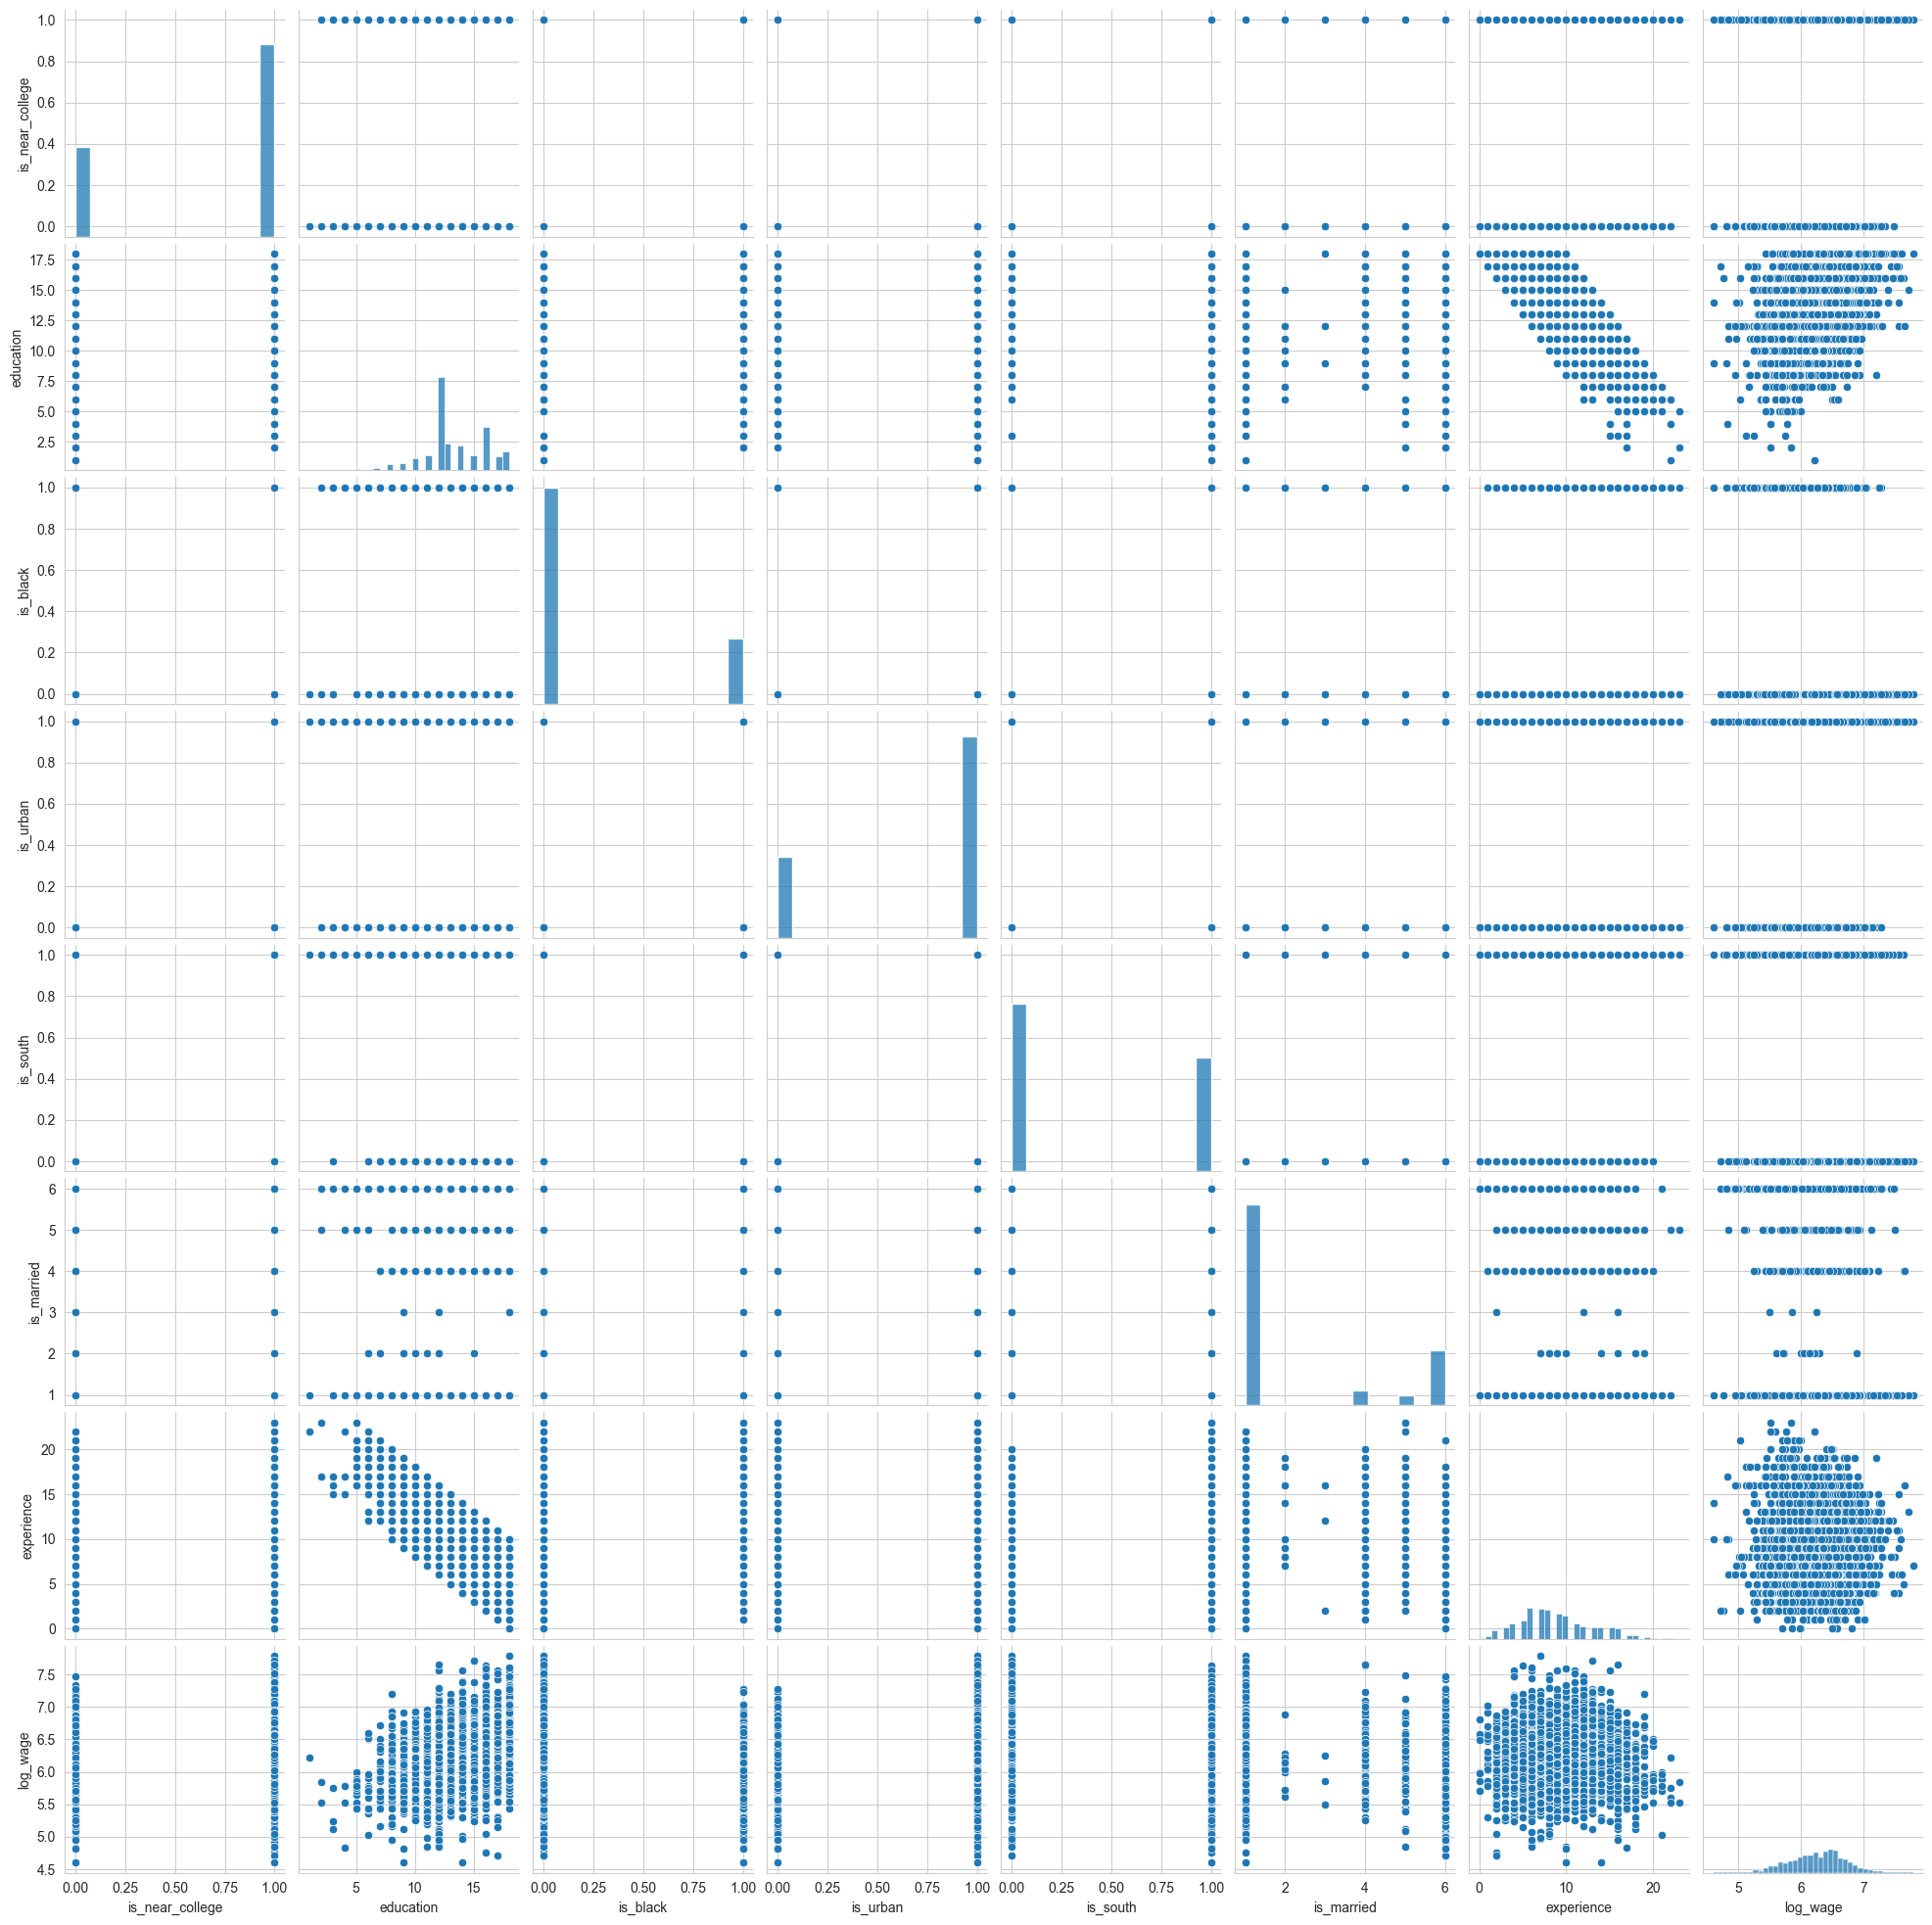

In [4]:
sns.pairplot(data)

In [5]:
@dataclass
class ConditionallyIndependentVariables:
    
    variable_a: str
    variable_b: str
    pearsons_r: float
    partial_corr_coef: float
    given: list[str]
    
    def is_conditionally_independent(self, alpha_level):
        return self.partial_corr_coef > alpha_level
    
    def graph_scatter_plot(self, data):
        sns.scatterplot(data, x=self.variable_b, y=self.variable_a)

In [6]:
alpha = 0.05
variables_conditions = []

for variable_x, variable_y in combinations(data.columns, 2):
    result = pg.partial_corr(data=data, x=variable_x, y=variable_y, covar=[])
    independences_vars = ConditionallyIndependentVariables(
        variable_a=variable_x,
        variable_b=variable_y,
        pearsons_r=float(result.r.iloc[0]),
        partial_corr_coef=float(result['p-val'].iloc[0]),
        given=[]
    )
    variables_conditions.append(independences_vars)

In [7]:
for var in variables_conditions:
    if not var.is_conditionally_independent(alpha):
        print(
            f"Variables {var.variable_a} "
            f"and {var.variable_b} "
            f"are{'' if var.is_conditionally_independent(alpha) else ' not'} "
            f"conditionally independent "
            f"with a score of: {var.partial_corr_coef:.2f}."
        )

Variables is_near_college and education are not conditionally independent with a score of: 0.00.
Variables is_near_college and is_black are not conditionally independent with a score of: 0.00.
Variables is_near_college and is_urban are not conditionally independent with a score of: 0.00.
Variables is_near_college and is_south are not conditionally independent with a score of: 0.00.
Variables is_near_college and experience are not conditionally independent with a score of: 0.00.
Variables is_near_college and log_wage are not conditionally independent with a score of: 0.00.
Variables education and is_black are not conditionally independent with a score of: 0.00.
Variables education and is_urban are not conditionally independent with a score of: 0.00.
Variables education and is_south are not conditionally independent with a score of: 0.00.
Variables education and is_married are not conditionally independent with a score of: 0.00.
Variables education and experience are not conditionally in

In [8]:
for var in variables_conditions:
    if var.is_conditionally_independent(alpha):
        print(
            f"Variables {var.variable_a} "
            f"and {var.variable_b} "
            f"are{'' if var.is_conditionally_independent(alpha) else ' not'} "
            f"conditionally independent "
            f"with a score of: {var.partial_corr_coef:.5f}."
        )

Variables is_near_college and is_married are conditionally independent with a score of: 0.37904.
Variables is_south and is_married are conditionally independent with a score of: 0.86852.
Variables experience and log_wage are conditionally independent with a score of: 0.49356.


The scatter plot, as well as the non-significant p-value (larger than $\alpha=0.05$) suggests that we fail to reject null hypothesis of independence; $X_1 \!\perp\!\!\!\perp X_2$, and therefore we remove the edge between the corresponding nodes.

In [9]:
for var in variables_conditions:
    if var.is_conditionally_independent(alpha):
        skeleton.remove_edge(var.variable_a, var.variable_b)


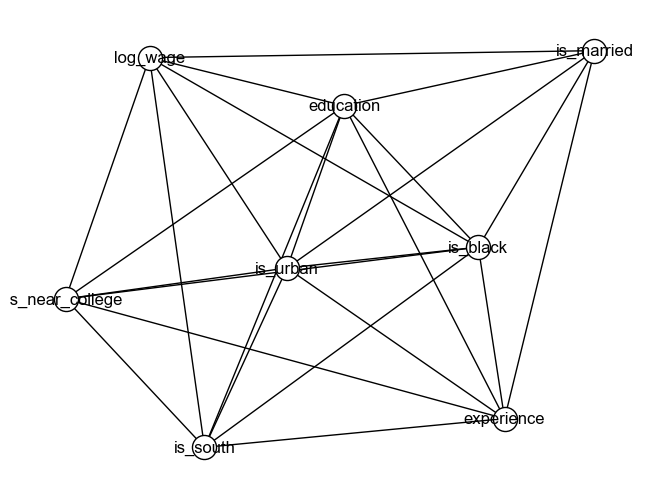

In [10]:
nx.draw_spring(skeleton, with_labels=True, node_color='w', edgecolors ='black')


In [11]:
def skeleton_learning(df, alpha=0.05):
    skeleton = nx.Graph(combinations(list(df.columns), 2))
    for (x, y) in combinations(skeleton.nodes(), 2):
        for k in range(len(skeleton.nodes())-1):
            for s in combinations(set(skeleton.nodes()).difference([x,y]), k):
                p_val = pg.partial_corr(data=df, x=x, y=y, covar=list(s)).round(3)['p-val'].item()
                if p_val > alpha and skeleton.has_edge(x, y):
                    print("removing edge: ", (x, y))
                    skeleton.remove_edge(x, y)
    return skeleton

skeleton = skeleton_learning(data)

removing edge:  ('is_near_college', 'is_black')
removing edge:  ('is_near_college', 'is_married')
removing edge:  ('is_near_college', 'experience')
removing edge:  ('is_near_college', 'log_wage')
removing edge:  ('education', 'is_urban')
removing edge:  ('education', 'is_south')
removing edge:  ('education', 'is_married')
removing edge:  ('is_black', 'is_urban')
removing edge:  ('is_black', 'experience')
removing edge:  ('is_urban', 'experience')
removing edge:  ('is_south', 'is_married')
removing edge:  ('is_south', 'experience')
removing edge:  ('experience', 'log_wage')


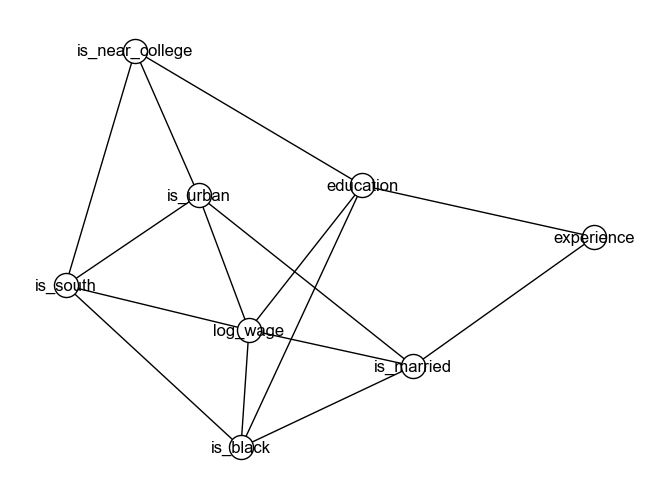

In [12]:
nx.draw_spring(skeleton, with_labels=True, node_color='w', edgecolors ='black')

**The full PC algorithm is available in the CausalDiscoveryTool (cdt) package**. The default CItest we use here is Gaussion CI test. There is also a list of options possible for different CI tests.
```CI_test = {'binary': "pcalg::binCItest", 
             'discrete': "pcalg::disCItest",
             'hsic_gamma': "kpcalg::kernelCItest",
             'hsic_perm': "kpcalg::kernelCItest",
             'hsic_clust': "kpcalg::kernelCItest",
             'gaussian': "pcalg::gaussCItest",
             'rcit': "RCIT:::CItest",
             'rcot': "RCIT:::CItest"}```

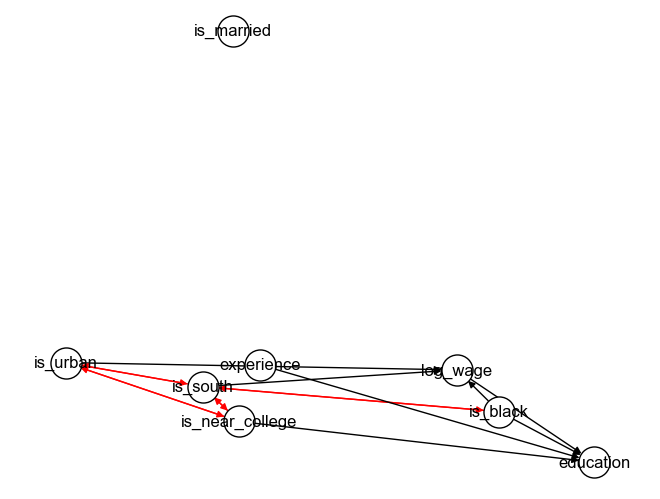

In [22]:
alpha = 0.05
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph = pc.create_graph_from_data(data)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', edge_color=colors)

In [43]:
from math import exp

data_copy = data.copy()
data_copy.log_wage = pd.qcut(data_copy.log_wage.apply(lambda x: exp(x)), q=5, labels=range(1, 6))

data_copy.dropna(inplace=True)

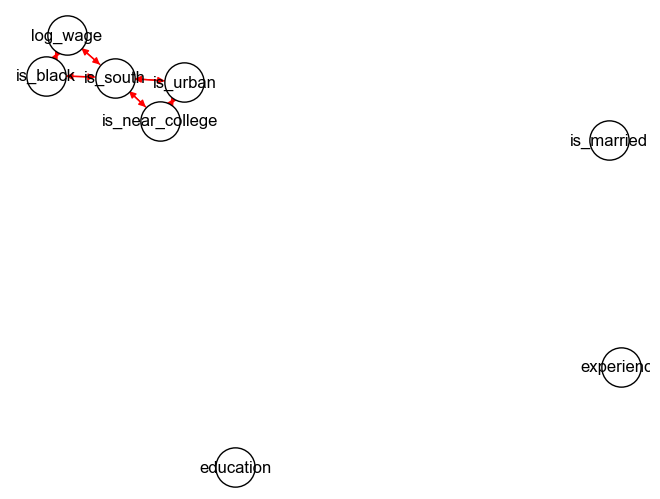

In [45]:
alpha = 0.05
pc = cdt.causality.graph.PC(CItest="discrete", alpha=alpha)
pc_graph = pc.create_graph_from_data(data_copy)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=800, node_color='w', edgecolors ='black', edge_color=colors)

In [46]:
data.head()

,is_near_college,education,is_black,is_urban,is_south,is_married,experience,log_wage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674


In [53]:
data.astype(
    {
        attributes.log_wage.translated: "float",
        attributes.experience.translated: "int",
        attributes.is_south.translated: "bool",
        attributes.is_married.translated: "bool",
        attributes.is_black.translated: "bool",
        attributes.is_urban.translated: "bool",
        attributes.is_near_college.translated: "bool",
        attributes.education.translated: "int",
        
    }

).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_near_college  3010 non-null   bool   
 1   education        3010 non-null   int64  
 2   is_black         3010 non-null   bool   
 3   is_urban         3010 non-null   bool   
 4   is_south         3010 non-null   bool   
 5   is_married       3010 non-null   bool   
 6   experience       3010 non-null   int64  
 7   log_wage         3010 non-null   float64
dtypes: bool(5), float64(1), int64(2)
memory usage: 85.4 KB


#### Optional: Running PC with background knowledge
In our example, adding background knowledge retrospecitvely resulted in a fully oriented graph. However, in general, orienting edges "manually" can result in mixed graphs in which Meek's rules can be applied again. Thus, it is best if background knowledge about edges is stated before applying SGS/PC. In `cdt` (and in the underlying `pcalg` package) we can only add the prior knowledge about the (non-)existence of edges, but not about their orientation. An example where the skeleton learning of the PC algorithm is forced to never remove the edge between $X_2$ and $X_5$ is shown below.

In [ ]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
### Define background knowledge ###
prior_graph = nx.DiGraph() # Create a graph to hold our background knowledge
prior_graph.add_nodes_from(['x1', 'x2', 'x3', 'x4', 'x5']) # Add nodes
prior_graph.add_edges_from([('x2', 'x5'), ('x5', 'x2')]) # Add prior knowledge of edge between X_2 and X_5 existing
fixed_edges = pd.DataFrame(nx.adjacency_matrix(prior_graph).todense()) # Symmetric adjacency matrix representing edges that exist
fixed_gaps = pd.DataFrame(np.zeros((5,5), dtype=int)) # Symmetric adjacency matrix representing edges that canNOT exist
### Run PC ###
pc.arguments['{CITEST}'] = pc.dir_CI_test[pc.CI_test]
pc.arguments['{METHOD_INDEP}'] = pc.dir_method_indep[pc.CI_test]
pc.arguments['{DIRECTED}'] = 'TRUE'
pc.arguments['{ALPHA}'] = str(pc.alpha)
pc.arguments['{NJOBS}'] = str(pc.njobs)
result = pc._run_pc(df, fixedEdges=fixed_edges, fixedGaps=fixed_gaps)
pc_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})
### Visalise ###
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

As we can see, the graph above contains the edge $X_2 \to X_5$, as required by our prior knowledge.

### Estimating in DoWhy

We can then use this graph in DoWhy and carry on causal effect estimation. Note that we can only use DAGs in DoWhy for the causal model. If the outputs from the PC algorithm are not DAGs then we are not able to use them directly in DoWhy.

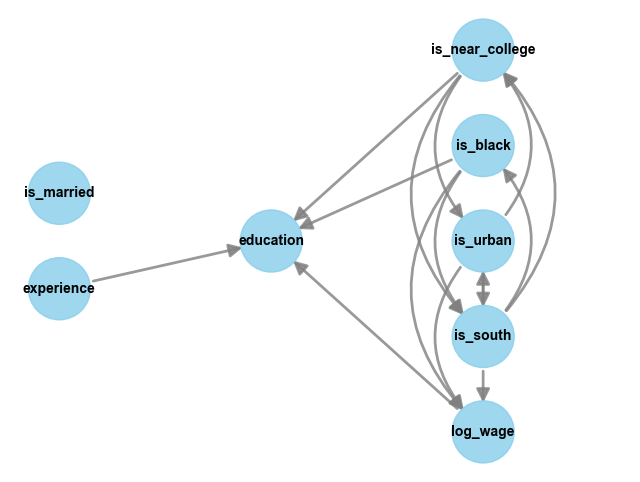

In [22]:
gml = ''.join(nx.generate_gml(pc_graph))
model = CausalModel(
        data = data,
        treatment=attributes.is_near_college.translated,
        outcome=attributes.log_wage.translated,
        graph=gml)
model.view_model()

In [23]:
identified_estimand = model.identify_effect()
print(identified_estimand)

NetworkXError: graph should be directed acyclic